# Statistical analysis

In [534]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scst
import pylab

datafilename = "data_processed.csv"
d = pd.read_csv(datafilename, index_col=0)

print("Loading:", len(d), "lines", len(d["ParticipantID"].unique()), "participants")
        
# ------------------------------------------------------
# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()


Loading: 15768 lines 219 participants


In [535]:
# remove outliers (responses outside mean + 2*STD)

def replace_outliers(d):
    means = d.groupby(["ParticipantID", "Type"])["RTnorm"].mean()
    stds = d.groupby(["ParticipantID", "Type"])["RTnorm"].std()
    meanorigs = d.groupby(["ParticipantID", "Type"])["RT"].mean()
    d.set_index(["ParticipantID", "Type", "TestID", "TrialID"], inplace=True)
    count = 0
    # traverse individual responses
    for ix, dt in d.iterrows():
        # get mean and std for participant and task type
        mean = means[ix[:-2]]
        std = stds[ix[:-2]]
        meanorig = meanorigs[ix[:-2]]
        if dt["RTnorm"] >= (mean + 2*std):
            count += 1
            d.loc[ix, "RT"] = meanorig
            d.loc[ix, "RTnorm"] = np.log(meanorig)
    d.reset_index(inplace=True)
    print("Replaced %d outliers" % count)
    # set RT norm again
    #d["RTnorm"] = np.log(d["RT"])
    return d
dwo = replace_outliers(d.copy())
print("Replacing outliers changes the global normalized mean from %.3f to %.3f" % (d["RTnorm"].mean(), dwo["RTnorm"].mean()))
print("Replacing outliers changes the global mean from %.3f to %.3f" % (d["RT"].mean(), dwo["RT"].mean()))

Replaced 557 outliers
Replacing outliers changes the global normalized mean from 7.756 to 7.719
Replacing outliers changes the global mean from 4017.465 to 2642.310


## Participants

In [536]:
TPP = 72  # there are 72 trials per participant
TPT = 36  # there are 36 trials per test
TPL = 20  # there are 20 trials per lexical test

for sid in [1, 2]:
    dt = d[d["StudyID"] == sid]
    if not dt.empty:
        print()
        print()
        print("## Counts for study ID:", sid)
        print()
        print("Number of participants:")
        print(len(dt) / TPP) 
        print()
        print("Fluent vs. non-fluent:")
        display(pd.DataFrame(dt["Fluent"].value_counts() / TPP))
        print()
        print("Different kinds of designers and which font was first:")
        
        dtt = pd.DataFrame(columns=["Designer", "Non-designer", "total"], index=["sansforgetica", "arial", "total"])
        dtt["Designer"] = dt[(dt["TestID"] == 1) & (dt["Type"] == "lexical") & (dt["Training"] != "Non-designer")]["Font"].value_counts()
        dtt["Non-designer"] = dt[(dt["TestID"] == 1) & (dt["Type"] == "lexical") & (dt["Training"] == "Non-designer")]["Font"].value_counts()
        dtt /=  TPL
        dtt["total"] = dtt.T.sum()
        dtt.loc["total"] = dtt.sum()
        display(dtt)
        print()
        display(pd.DataFrame(dt["Training"].value_counts() / TPP))

        print("JoM for categories of training:")
        display(pd.DataFrame(dt.groupby("Training")["JoM"].mean()))
        print()
        print("JoL for categories of training:")
        display(pd.DataFrame(dt.groupby("Training")["JoL"].value_counts() / TPT))




## Counts for study ID: 1

Number of participants:
97.0

Fluent vs. non-fluent:


,Fluent
True,89.0
False,8.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,26.0,21.0,47.0
arial,27.0,23.0,50.0
total,53.0,44.0,97.0


,Training
Non-designer,44.0
Letter designer,25.0
Graphic designer,17.0
Other designer,6.0
Typographer,5.0


JoM for categories of training:


,JoM
Training,
Graphic designer,56.735294
Letter designer,55.160000
Non-designer,53.977273
Other designer,49.166667
Typographer,61.000000



JoL for categories of training:


JoL
Training         JoL                         
Graphic designer very easy to read       13.0
                 ok                      10.0
                 easy to read             5.0
                 difficult to read        4.0
                 very difficult to read   2.0
Letter designer  very easy to read       14.0
                 difficult to read       13.0
                 ok                      11.0
                 easy to read             9.0
                 very difficult to read   3.0
Non-designer     very easy to read       38.0
                 ok                      22.0
                 difficult to read       14.0
                 easy to read            12.0
                 very difficult to read   2.0
Other designer   very easy to read        5.0
                 ok                       4.0
                 difficult to read        2.0
                 very difficult to read   1.0
Typographer      very easy to read        4.0
                 difficult to read        3.0
                 ok                       2.0
                 easy to read             1.0



## Counts for study ID: 2

Number of participants:
122.0

Fluent vs. non-fluent:


,Fluent
True,106.0
False,16.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,31.0,29.0,60.0
arial,32.0,30.0,62.0
total,63.0,59.0,122.0


,Training
Non-designer,59.0
Graphic designer,28.0
Letter designer,16.0
Other designer,12.0
Typographer,7.0


JoM for categories of training:


,JoM
Training,
Graphic designer,53.875000
Letter designer,59.562500
Non-designer,52.237288
Other designer,53.083333
Typographer,59.000000



JoL for categories of training:


JoL
Training         JoL                         
Graphic designer very easy to read       23.0
                 difficult to read       12.0
                 ok                      11.0
                 easy to read            10.0
Letter designer  difficult to read       13.0
                 easy to read             7.0
                 very easy to read        7.0
                 ok                       4.0
                 very difficult to read   1.0
Non-designer     very easy to read       51.0
                 ok                      26.0
                 difficult to read       18.0
                 easy to read            17.0
                 very difficult to read   6.0
Other designer   very easy to read        8.0
                 difficult to read        6.0
                 easy to read             5.0
                 ok                       4.0
                 very difficult to read   1.0
Typographer      ok                       6.0
                 very easy to read        5.0
                 easy to read             3.0

## Calculating AUC and RT

In [537]:

map_JoL = {
    "very easy to read": 100,
    "easy to read": 75,
    "ok": 50,
    "difficult to read": 25,
    "very difficult to read": 0,
}

def get_agg_results(d):
    """
    Aggregate data for every (study, test, participant) combination.
    Calculate AUC and RT across all of their relevant responses
    (originally 36 trials, but could be less after outliers were removed)
    and average them for: all, words,  and non-words.
    """

    # prepare empty results DataFrame
    # aggregate correct and response time (use mean value)
    # the rest is either copied or new (NaN value)
    result_columns = ["StudyID", "ParticipantID", "TestID", "Type", "Order", "Firstfont",
                      "Fluent", "Training", "isDesigner", "Font", "Correct", "RT", "RTnorm",
                      "RT_word", "RT_nonword", "RTnorm_word", "RTnorm_nonword",
                      "AUC", "AUC_word", "AUC_nonword",
                      "JoL", "JoM", "Date"]
    agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
    agg_columns["Correct"] = "mean"
    agg_columns["RT"] = "mean"
    agg_columns["RTnorm"] = "mean"
    results = d.groupby(["StudyID", "ParticipantID", "TestID", "Type"]).agg(agg_columns)
    results = pd.DataFrame(results, columns=result_columns)
    results.set_index(["StudyID", "ParticipantID", "TestID", "Type"], inplace=True)
    results["isDesigner"] = results["Training"] != "Non-designer" # to conveniently group designers together
    for k, v in map_JoL.items():
        results["JoL"] = results["JoL"].astype(str).replace(k, v)
    results["JoL"] = results["JoL"].astype(float)

    test_ids = set(d["TestID"].unique())
    
    # prepare indexes for temporary data frames
    # there are two, one based on the Category column used for lexical tasks
    # and one based on the Seen column used for recognition
    ix = {}
    category_used = "Category"
    categories = ["word", "non-word"]
    responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
    ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
    category_used = "Seen"
    categories = ["seen", "not seen"]
    responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
    ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

    # loop across study IDs, participant IDs, Test IDs, and Test types
    # to get each part separately
    for sid in d["StudyID"].unique():
        for pid in d[d["StudyID"] == sid]["ParticipantID"].unique():
            for tid in test_ids:
                for order, ttype in enumerate(sorted(dt["Type"].unique())):
                    # focus the data frame
                    dtt = d[(d["StudyID"] == sid) & (d["ParticipantID"] == pid) & (d["TestID"] == tid) & (d["Type"] == ttype)]
                    # figure out which category and index to use for this Test type
                    category_used, index = ix[ttype]
                    # get/save the order of tests
                    if sid == 1:
                        # in study #1 it corresponds to 1 = lexical, 2 = recognition
                        results.loc[(sid, pid, tid, ttype), "Order"] = [1, 2][order]
                    else:
                        # in study #2 it depends on the Test ID
                        if tid == 1:
                            results.loc[(sid, pid, tid, ttype), "Order"] = [1, 2][order]
                        elif tid == 2:
                            results.loc[(sid, pid, tid, ttype), "Order"] = [2, 1][order]
                    
                    # to calculate the AUC, get response frequencies for each test type first
                    # ensure the order in the index is always the same
                    dg = pd.DataFrame(index=index)
                    dg["Frequencies"] = dtt.groupby([category_used])["Response"].value_counts()
                    dg = dg.fillna(0)
                    
                    # calculate the AUC
                    # use frequencies for word/seen for the y coordinate
                    # use frequencies for non-word/not seen for the x coordinate
                    freqs = dg["Frequencies"].tolist()
                    auc = get_auc(freqs[4:], freqs[:4])
                    results.loc[(sid, pid, tid, ttype), "AUC"] = auc

                    # get the mean AUC and RT for words and non-words
                    for cat in ["word", "non-word"]:
                        cat_ = cat.replace("-", "")
                        if ttype == "recognition":
                            dg["Frequencies"] = dtt[dtt["Category"] == cat].groupby([category_used])["Response"].value_counts()
                            dg = dg.fillna(0)
                            freqs = dg["Frequencies"].tolist()
                            auc = get_auc(freqs[4:], freqs[:4])
                            results.loc[(sid, pid, tid, ttype), "AUC_%s" % cat_] = auc
                        rt = dtt[dtt["Category"] == cat]["RT"].mean()
                        results.loc[(sid, pid, tid, ttype), "RT_%s" % cat_] = rt
                        rt = dtt[dtt["Category"] == cat]["RTnorm"].mean()
                        results.loc[(sid, pid, tid, ttype), "RTnorm_%s" % cat_] = rt
            results.loc[(sid, pid), "Firstfont"] = results.loc[(sid, pid, 1, "lexical"), "Font"]
    # fix the type for order column
    results["Order"] = results["Order"].astype(int)
    # swap recognition tests for SID == 2
    # to have lexical and recognition next to each other
    for pid in d[d["StudyID"] == 2]["ParticipantID"].unique():
        backup = results.loc[(2, pid, 1, "recognition")].copy()
        results.loc[(2, pid, 1, "recognition")] = results.loc[(2, pid, 2, "recognition")]
        results.loc[(2, pid, 2, "recognition")] = backup
      
    return results

results = get_agg_results(d)
resultswo = get_agg_results(dwo)
display(results[-4:])
results.reset_index(inplace=True)
resultswo.reset_index(inplace=True)

# save
results.to_csv(datafilename.replace("_processed.csv", "_stats.csv"))
resultswo.to_csv(datafilename.replace("_processed.csv", "_stats-outliers-replaced.csv"))
dwo.to_csv(datafilename.replace("_processed.csv", "_processed-outliers-replaced.csv"))

Order Firstfont  Fluent  \
StudyID ParticipantID TestID Type                                   
2       121           1      lexical          1     arial    True   
                             recognition      1     arial    True   
                      2      lexical          2     arial    True   
                             recognition      2     arial    True   

                                              Training  isDesigner  \
StudyID ParticipantID TestID Type                                    
2       121           1      lexical      Non-designer       False   
                             recognition  Non-designer       False   
                      2      lexical      Non-designer       False   
                             recognition  Non-designer       False   

                                                   Font  Correct        RT  \
StudyID ParticipantID TestID Type                                            
2       121           1      lexical              arial   0.9500  2817.600   
                             recognition          arial   0.5625  2763.000   
                      2      lexical      sansforgetica   1.0000  2655.300   
                             recognition  sansforgetica   0.7500  3352.125   

                                            RTnorm   RT_word  RT_nonword  \
StudyID ParticipantID TestID Type                                          
2       121           1      lexical      7.882604  2083.300    3551.900   
                             recognition  7.864263  2567.125    2958.875   
                      2      lexical      7.821847  1993.700    3316.900   
                             recognition  8.073008  3185.250    3519.000   

                                          RTnorm_word  RTnorm_nonword  \
StudyID ParticipantID TestID Type                                       
2       121           1      lexical         7.612399        8.152810   
                             recognition     7.766479        7.962047   
                      2      lexical         7.567908        8.075785   
                             recognition     8.000525        8.145492   

                                               AUC  AUC_word  AUC_nonword  \
StudyID ParticipantID TestID Type                                           
2       121           1      lexical      1.000000       NaN          NaN   
                             recognition  0.648438   0.65625      0.71875   
                      2      lexical      1.000000       NaN          NaN   
                             recognition  0.812500   0.93750      0.75000   

                                           JoL  JoM              Date  
StudyID ParticipantID TestID Type                                      
2       121           1      lexical      75.0   50  12-04-2019 09:34  
                             recognition  25.0   46  12-04-2019 09:34  
                      2      lexical      25.0   46  12-04-2019 09:34  
                             recognition  75.0   50  12-04-2019 09:34

# Asess normality of RTs

Normality test for RTnorms in lexical task
Shapiro: statistic: 0.9532, p-value: 0.000000
D’Agostino: statistic: 49.2383, p-value: 0.0000
Skew: statistic: 4.1482, p-value: 0.0000
Kurtosis: statistic: 5.6596, p-value: 0.0000

Without outliers:
Shapiro: statistic: 0.9501, p-value: 0.000000
D’Agostino: statistic: 52.5043, p-value: 0.0000
Skew: statistic: 4.2840, p-value: 0.0000
Kurtosis: statistic: 5.8439, p-value: 0.0000

------------------------------
Normality test for RTnorms in recognition task
Shapiro: statistic: 0.9500, p-value: 0.000000
D’Agostino: statistic: 51.1133, p-value: 0.0000
Skew: statistic: -1.4316, p-value: 0.1523
Kurtosis: statistic: 7.0046, p-value: 0.0000

Without outliers:
Shapiro: statistic: 0.9499, p-value: 0.000000
D’Agostino: statistic: 50.3773, p-value: 0.0000
Skew: statistic: -1.8288, p-value: 0.0674
Kurtosis: statistic: 6.8580, p-value: 0.0000

------------------------------


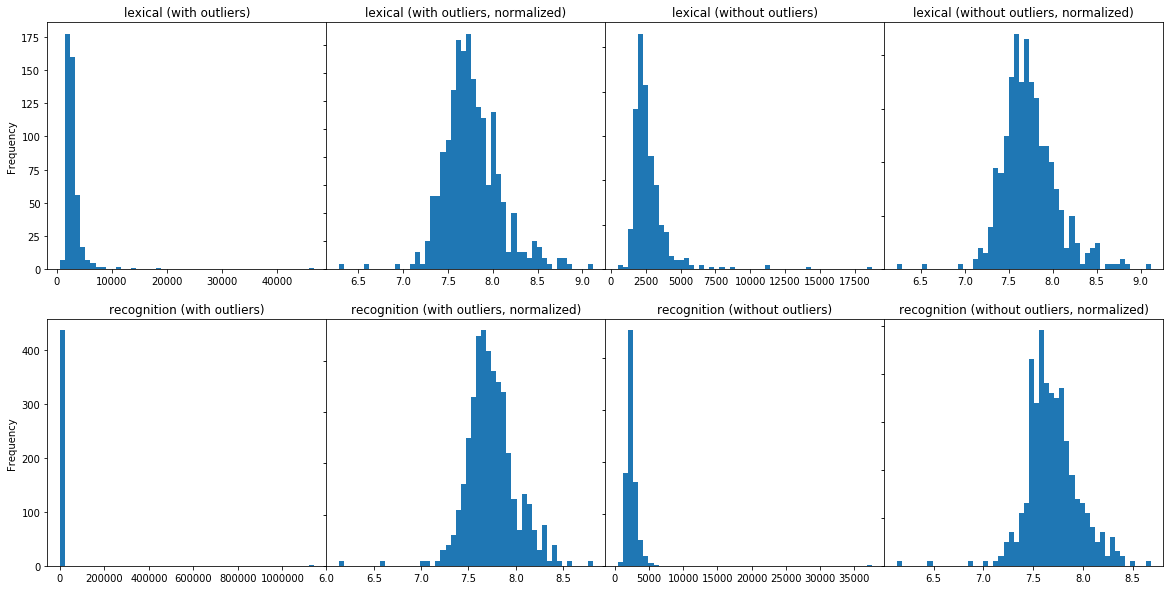

In [538]:
# assess normality of RTs

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(wspace=0, hspace=0.2)
for i, ttype in enumerate(["lexical", "recognition"]):
    rts = results[results["Type"] == ttype]["RT"]
    rts.plot.hist(bins=50, ax=axes[i][0], sharey=True, title="%s (with outliers)" % ttype)
    rts = results[results["Type"] == ttype]["RTnorm"]
    rts.plot.hist(bins=50, ax=axes[i][1], sharey=True, title="%s (with outliers, normalized)" % ttype)
    
    rts = resultswo[resultswo["Type"] == ttype]["RT"]
    rts.plot.hist(bins=50, ax=axes[i][2], sharey=True, title="%s (without outliers)" % ttype)
    rts = resultswo[resultswo["Type"] == ttype]["RTnorm"]
    rts.plot.hist(bins=50, ax=axes[i][3], sharey=True, title="%s (without outliers, normalized)" % ttype)
    
# test for normality
# null hypothesis: RTs come from a normal distribution
for ttype in ["lexical", "recognition"]:
    for col in ["RTnorm"]:
        print("Normality test for %ss in %s task" % (col, ttype))
        rts = results[results["Type"] == ttype][col]
        print("Shapiro: statistic: %.4f, p-value: %.6f" % scst.shapiro(rts))
        print("D’Agostino: statistic: %.4f, p-value: %.4f" % scst.normaltest(rts))
        print("Skew: statistic: %.4f, p-value: %.4f" % scst.skewtest(rts))
        print("Kurtosis: statistic: %.4f, p-value: %.4f" % scst.kurtosistest(rts))
        print()
        print("Without outliers:")
        rts = resultswo[resultswo["Type"] == ttype][col]
        print("Shapiro: statistic: %.4f, p-value: %.6f" % scst.shapiro(rts))
        print("D’Agostino: statistic: %.4f, p-value: %.4f" % scst.normaltest(rts))
        print("Skew: statistic: %.4f, p-value: %.4f" % scst.skewtest(rts))
        print("Kurtosis: statistic: %.4f, p-value: %.4f" % scst.kurtosistest(rts))
        print()
        print(30*"-")

((array([-3.77775802, -3.55076281, -3.42605454, ...,  3.42605454,
          3.55076281,  3.77775802]),
  array([ 5.88610403,  5.94542061,  5.96870756, ..., 10.71876387,
         10.87579939, 11.02351881])),
 (0.5353911533639386, 7.736981392925203, 0.9843070910176949))

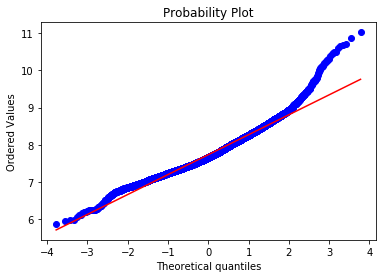

In [539]:
rts = dwo[dwo["Type"] == "lexical"]["RTnorm"]
scst.probplot(rts, dist="norm", plot=pylab)

((array([-3.72180189, -3.49159787, -3.36497218, ...,  3.36497218,
          3.49159787,  3.72180189]),
  array([ 6.04263283,  6.04737218,  6.06842559, ...,  9.50435237,
          9.57637141, 13.25524081])),
 (0.44771041494465547, 7.695645343735145, 0.9887207760694697))

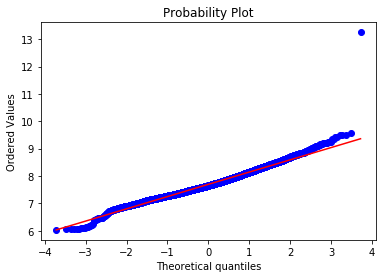

In [540]:
rts = dwo[dwo["Type"] == "recognition"]["RTnorm"]
scst.probplot(rts, dist="norm", plot=pylab)